# Step 4: Machine Learning for Low-Rate DDoS Detection

This notebook performs the following steps:
1. **Data Preprocessing:** Load the preprocessed dataset, remove unneeded columns, perform type conversions, and inspect for abnormal values.
2. **Feature Standardization & Train-Test Split:** Standardize selected features, split the data into training and test sets, and then perform stratified sampling on the training set to reduce its size while maintaining class distribution.
3. **Model Training & Evaluation:** Train multiple models (MLP, SVM, Random Forest, Logistic Regression, XGBoost) in separate cells. Each cell outputs the model's performance metrics (Accuracy, Precision, Recall, F1-Score) along with a bar chart.
4. **Summary:** Finally, aggregate all results into a summary table and grouped bar chart.

The target attack for Low-Rate DDoS is assumed to be **DDoS-SlowLoris**.

## 1. Data Preprocessing

Load the preprocessed dataset (`preprocessed_CICIoT2023.csv`), inspect its structure, and display descriptive statistics.

In [3]:
import pandas as pd
import numpy as np

# Load the preprocessed dataset
data = pd.read_csv("preprocessed_CICIoT2023.csv")
print("Dataset shape:", data.shape)
print("Columns:", data.columns.tolist())

# Display first 5 rows
print(data.head())

# Descriptive statistics to check for abnormal values
print(data.describe())

Dataset shape: (2366956, 47)
Columns: ['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight', 'label']
   flow_duration  Header_Length  Protocol Type  Duration       Rate  \
0       4.625763           84.0           17.0      64.0   0.432361   
1      76.135781       428611.8            8.2     151.9  42.352135   
2       4.549627          108.0            6.0      64.0   0.762226   
3       0.000000           54.0            6.0      64.0   0.000000   
4       0.000000            0.0            1.0      64.0   3.178249   

     

### Remove Unneeded Columns

Based on prior analysis, we keep only the candidate features that were important and the `label` column. 

Selected candidate features:
- **flow_duration**
- **Rate**
- **Srate**
- **IAT**
- **Radius**
- **Magnitue**
- **Variance**
- **Number**
- **Weight**
- **ack_flag_number**

We drop features such as `Drate` and `syn_flag_number`.

In [6]:
# Define candidate features to keep
candidate_features = [
    "flow_duration",
    "Rate",
    "Srate",
    "IAT",
    "Radius",
    "Magnitue",
    "Variance",
    "Number",
    "Weight",
    "ack_flag_number"
]

# Create a new DataFrame with the candidate features and label
df_ml = data[candidate_features + ["label"]].copy()
print("DataFrame shape after selecting candidate features:", df_ml.shape)

# Display descriptive statistics
print(df_ml.describe())

DataFrame shape after selecting candidate features: (2366956, 11)
       flow_duration          Rate         Srate           IAT        Radius  \
count   2.366956e+06  2.366956e+06  2.366956e+06  2.366956e+06  2.366956e+06   
mean    5.799154e+00  9.071399e+03  9.071399e+03  8.318651e+07  4.724560e+01   
std     2.886420e+02  9.996886e+04  9.996886e+04  1.706606e+07  2.279241e+02   
min     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%     0.000000e+00  2.096417e+00  2.096417e+00  8.307157e+07  0.000000e+00   
50%     0.000000e+00  1.582196e+01  1.582196e+01  8.312452e+07  0.000000e+00   
75%     1.045313e-01  1.180339e+02  1.180339e+02  8.334390e+07  5.059213e-01   
max     9.943576e+04  8.388608e+06  8.388608e+06  1.676394e+08  1.555106e+04   

           Magnitue      Variance        Number        Weight  ack_flag_number  
count  2.366956e+06  2.366956e+06  2.366956e+06  2.366956e+06     2.366956e+06  
mean   1.312455e+01  9.648163e-02  9.498601e+00  1.

## 2. Feature Standardization and Train-Test Split

Create a binary target column (`is_low_rate`) for Low-Rate DDoS (1 for `DDoS-SlowLoris`, 0 otherwise), standardize the features, and split the data into training and test sets.

**Additional Step:** To speed up training, we perform stratified sampling on the training set to reduce its size while maintaining the class distribution.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Create binary target column: 1 if label equals 'DDoS-SlowLoris', else 0
target_label = "DDoS-SlowLoris"
df_ml["is_low_rate"] = (df_ml["label"] == target_label).astype(int)

# Define feature matrix X and target vector y
X = df_ml[candidate_features]
y = df_ml["is_low_rate"]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (1656869, 10)
Test set shape: (710087, 10)


In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

# Perform stratified sampling on the training set to reduce its size
sample_fraction = 0.1  # Use 10% of the training set
sss = StratifiedShuffleSplit(n_splits=1, train_size=sample_fraction, random_state=42)
for train_index, _ in sss.split(X_train, y_train):
    X_train_sampled = X_train[train_index]
    # If y_train is a pandas Series, use .iloc for indexing
    y_train_sampled = y_train.iloc[train_index]

print("Sampled training set shape:", X_train_sampled.shape)

Sampled training set shape: (165686, 10)


## 3. Model Training and Evaluation: MLPClassifier

Train an MLP classifier on the sampled training set, evaluate its performance (Accuracy, Precision, Recall, F1-Score), and display the results in a bar chart.

MLP: Accuracy=0.9995, Precision=0.7879, Recall=0.0737, F1-Score=0.1347


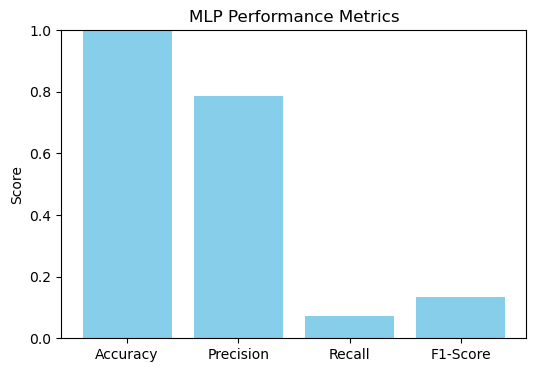

In [14]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

mlp = MLPClassifier(random_state=42, max_iter=500)
mlp.fit(X_train_sampled, y_train_sampled)
y_pred_mlp = mlp.predict(X_test)

acc = accuracy_score(y_test, y_pred_mlp)
prec = precision_score(y_test, y_pred_mlp, zero_division=0)
rec = recall_score(y_test, y_pred_mlp, zero_division=0)
f1 = f1_score(y_test, y_pred_mlp, zero_division=0)

results = {}
results["MLP"] = {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1-Score": f1}
print(f"MLP: Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1-Score={f1:.4f}")

# Bar chart for MLP metrics
metrics = {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1-Score": f1}
plt.figure(figsize=(6,4))
plt.bar(metrics.keys(), metrics.values(), color='skyblue')
plt.ylim(0,1)
plt.title("MLP Performance Metrics")
plt.ylabel("Score")
plt.show()

## 3. Model Training and Evaluation: SVM

Train an SVM classifier on the sampled training set, evaluate its performance, and display the results.

SVM: Accuracy=0.9995, Precision=0.9286, Recall=0.0368, F1-Score=0.0708


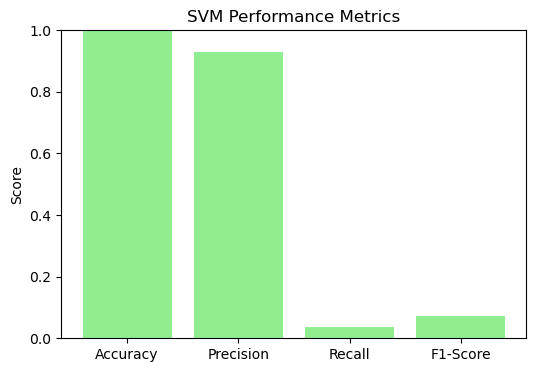

In [17]:
from sklearn.svm import SVC

svm = SVC(random_state=42, probability=True)
svm.fit(X_train_sampled, y_train_sampled)
y_pred_svm = svm.predict(X_test)

acc = accuracy_score(y_test, y_pred_svm)
prec = precision_score(y_test, y_pred_svm, zero_division=0)
rec = recall_score(y_test, y_pred_svm, zero_division=0)
f1 = f1_score(y_test, y_pred_svm, zero_division=0)

results["SVM"] = {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1-Score": f1}
print(f"SVM: Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1-Score={f1:.4f}")

# Bar chart for SVM metrics
metrics = {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1-Score": f1}
plt.figure(figsize=(6,4))
plt.bar(metrics.keys(), metrics.values(), color='lightgreen')
plt.ylim(0,1)
plt.title("SVM Performance Metrics")
plt.ylabel("Score")
plt.show()

## 3. Model Training and Evaluation: Random Forest

Train a Random Forest classifier on the sampled training set, evaluate its performance, and display the results.

Random Forest: Accuracy=1.0000, Precision=1.0000, Recall=0.9263, F1-Score=0.9618


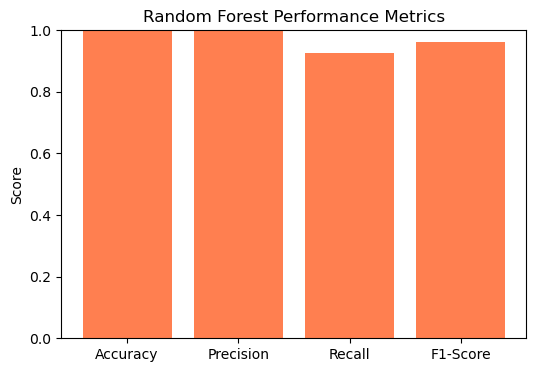

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_sampled, y_train_sampled)
y_pred_rf = rf.predict(X_test)

acc = accuracy_score(y_test, y_pred_rf)
prec = precision_score(y_test, y_pred_rf, zero_division=0)
rec = recall_score(y_test, y_pred_rf, zero_division=0)
f1 = f1_score(y_test, y_pred_rf, zero_division=0)

results["Random Forest"] = {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1-Score": f1}
print(f"Random Forest: Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1-Score={f1:.4f}")

# Bar chart for Random Forest metrics
metrics = {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1-Score": f1}
plt.figure(figsize=(6,4))
plt.bar(metrics.keys(), metrics.values(), color='coral')
plt.ylim(0,1)
plt.title("Random Forest Performance Metrics")
plt.ylabel("Score")
plt.show()

## 3. Model Training and Evaluation: Logistic Regression

Train a Logistic Regression classifier on the sampled training set, evaluate its performance, and display the results.

Logistic Regression: Accuracy=0.9995, Precision=0.0000, Recall=0.0000, F1-Score=0.0000


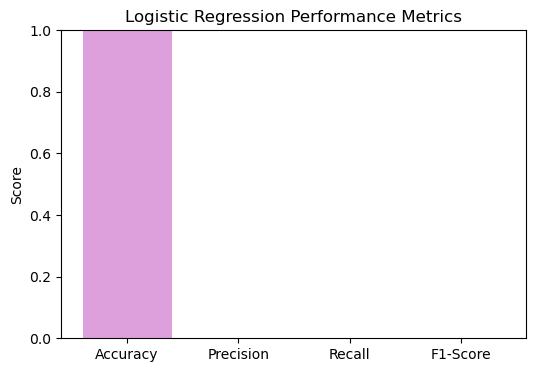

In [25]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_sampled, y_train_sampled)
y_pred_lr = lr.predict(X_test)

acc = accuracy_score(y_test, y_pred_lr)
prec = precision_score(y_test, y_pred_lr, zero_division=0)
rec = recall_score(y_test, y_pred_lr, zero_division=0)
f1 = f1_score(y_test, y_pred_lr, zero_division=0)

results["Logistic Regression"] = {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1-Score": f1}
print(f"Logistic Regression: Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1-Score={f1:.4f}")

# Bar chart for Logistic Regression metrics
metrics = {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1-Score": f1}
plt.figure(figsize=(6,4))
plt.bar(metrics.keys(), metrics.values(), color='plum')
plt.ylim(0,1)
plt.title("Logistic Regression Performance Metrics")
plt.ylabel("Score")
plt.show()

## 3. Model Training and Evaluation: XGBoost

Train an XGBoost classifier on the sampled training set, evaluate its performance, and display the results.

XGBoost: Accuracy=0.9999, Precision=0.9117, Recall=0.8187, F1-Score=0.8627


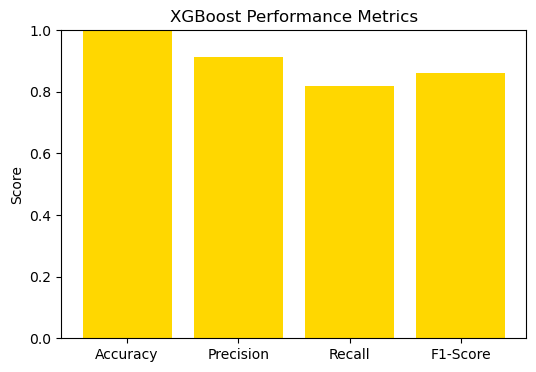

In [81]:
from xgboost import XGBClassifier

#xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb = XGBClassifier(eval_metric='logloss', random_state=42)

xgb.fit(X_train_sampled, y_train_sampled)
y_pred_xgb = xgb.predict(X_test)

acc = accuracy_score(y_test, y_pred_xgb)
prec = precision_score(y_test, y_pred_xgb, zero_division=0)
rec = recall_score(y_test, y_pred_xgb, zero_division=0)
f1 = f1_score(y_test, y_pred_xgb, zero_division=0)

results["XGBoost"] = {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1-Score": f1}
print(f"XGBoost: Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1-Score={f1:.4f}")

# Bar chart for XGBoost metrics
metrics = {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1-Score": f1}
plt.figure(figsize=(6,4))
plt.bar(metrics.keys(), metrics.values(), color='gold')
plt.ylim(0,1)
plt.title("XGBoost Performance Metrics")
plt.ylabel("Score")
plt.show()

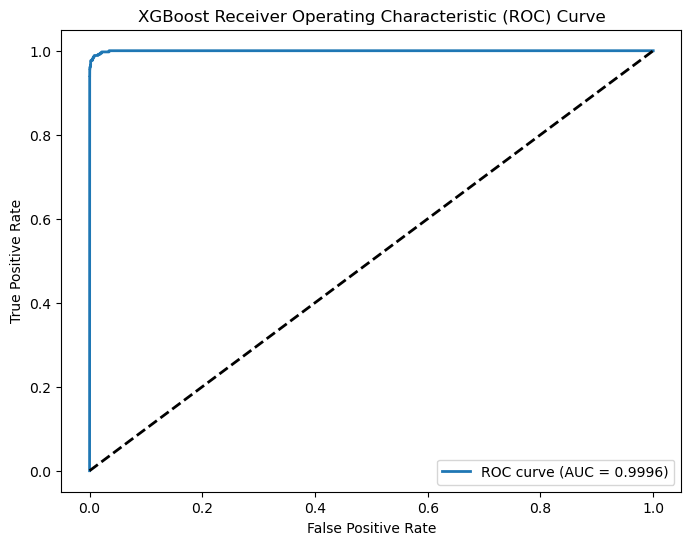

In [154]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

# XGBoost
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

# Calculate ROC and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_xgb)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)  # Random guessed baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


# Calculate Precision-Recall curve and AUC
#precision, recall, thresholds_pr = precision_recall_curve(y_test, y_proba_xgb)
#pr_auc = auc(recall, precision)

#plt.figure(figsize=(8, 6))
#plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.4f})', linewidth=2)
#plt.xlabel('Recall')
#plt.ylabel('Precision')
#plt.title('XGBoost Precision-Recall (PR) Curve')
#plt.legend(loc='lower left')
#plt.show()


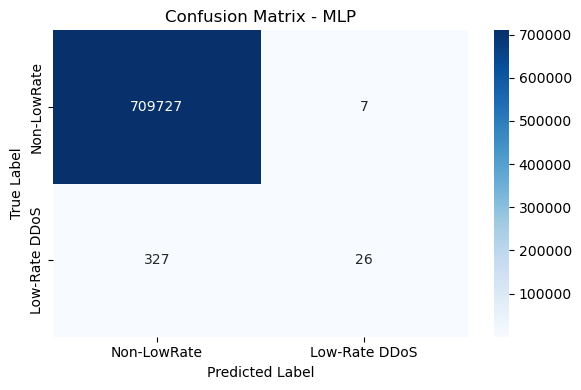

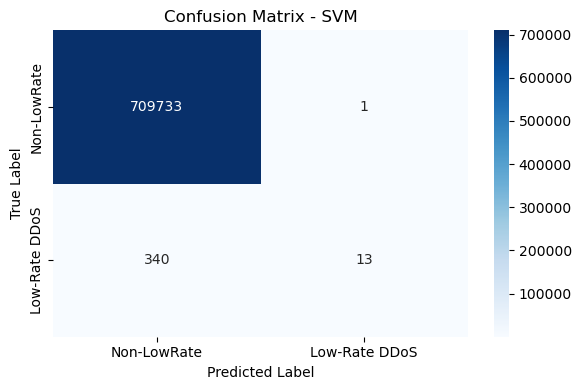

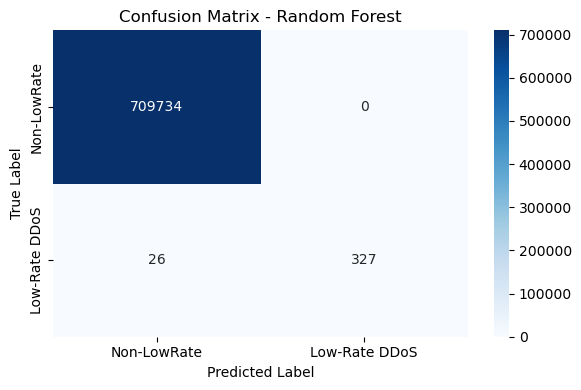

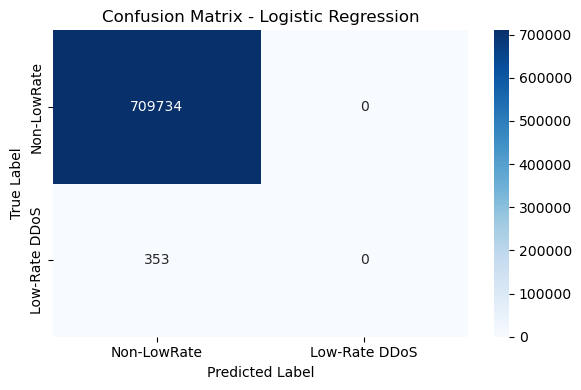

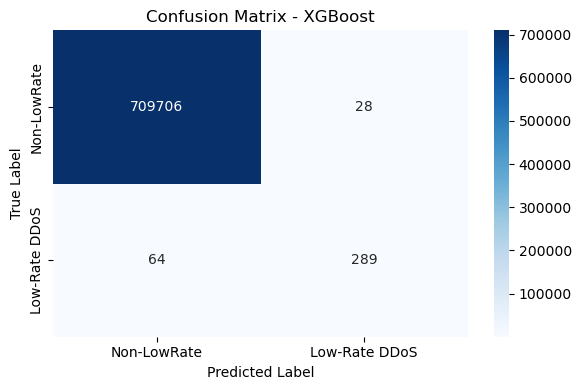

In [102]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define custom labels for the binary classification
class_labels = ["Non-LowRate", "Low-Rate DDoS"]

# Iterate over each model, predict on the test set, and plot the confusion matrix
models_dict = {
    "MLP": mlp,
    "SVM": svm,
    "Random Forest": rf,
    "Logistic Regression": lr,
    "XGBoost": xgb
}

for name, model in models_dict.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

## 4. Summary of Results

Aggregate the performance metrics from all models into a summary table and visualize them using a grouped bar chart.

### Summary Table of Model Performance ###


,Accuracy,Precision,Recall,F1-Score
MLP,0.999530,0.787879,0.073654,0.134715
SVM,0.999520,0.928571,0.036827,0.070845
Random Forest,0.999963,1.000000,0.926346,0.961765
Logistic Regression,0.999503,0.000000,0.000000,0.000000
XGBoost,0.999870,0.911672,0.818697,0.862687


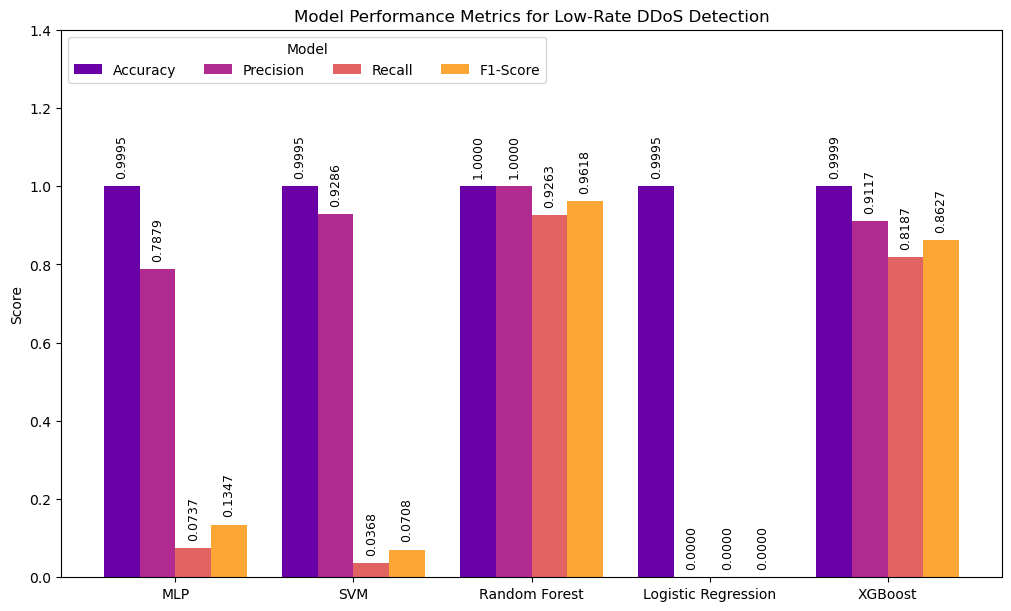

In [146]:
# Convert the results dictionary to a DataFrame
results_df = pd.DataFrame(results).T
print("### Summary Table of Model Performance ###")
display(results_df)

# Get model names and metric names
models = results_df.index.tolist()      # Model names
metrics = results_df.columns.tolist()     # Performance metrics

# Define a color palette for the metrics using seaborn's 'deep' palette
colors_metrics = sns.color_palette("plasma", len(metrics))
metrics_palette = dict(zip(metrics, colors_metrics))

# Set positions for the bars
x = np.arange(len(models))                # the label locations
width = 0.2                               # the width of each bar
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(10, 6))

# Plot each metric as a set of bars in their fixed color
for metric in metrics:
    offset = width * multiplier
    values = results_df[metric].values
    rects = ax.bar(x + offset, values, width, label=metric, color=metrics_palette[metric])
    # Annotate each bar with its value, rotated vertically (90°)
    for bar in rects:
        ax.text(bar.get_x() + bar.get_width()/2, 
                bar.get_height() + 0.02, 
                f"{bar.get_height():.4f}", 
                ha='center', va='bottom', fontsize=9, rotation=90)
    multiplier += 1

# Center the x-axis tick labels over the grouped bars
ax.set_xticks(x + width * (len(metrics) - 1) / 2)
ax.set_xticklabels(models)
ax.set_ylabel('Score')
ax.set_title('Model Performance Metrics for Low-Rate DDoS Detection')
ax.legend(loc='upper left', ncols=len(metrics))
ax.set_ylim(0, 1.4)
plt.legend(title='Model', loc='upper left', ncol=5)
plt.show()

## Detailed Analysis

### 1. Accuracy
- All models show very high accuracy (around 99.95% or higher).  
- However, with severe class imbalance, accuracy is not an effective measure because even a model that predicts only the majority class can achieve high accuracy.

### 2. Precision
- **Random Forest** achieves perfect precision (1.0000), indicating that every instance it predicts as positive (Low-Rate DDoS) is correct.
- **SVM** and **XGBoost** also have high precision (0.9286 and 0.9117, respectively), meaning they are reliable when they do predict a positive.
- **MLP** shows a moderate precision (0.7879), while **Logistic Regression** has 0 precision, implying it never predicts the positive class correctly.

### 3. Recall
- **Random Forest** and **XGBoost** have high recall (0.9263 and 0.8187, respectively), which means they are able to identify the majority of actual positive cases.
- **MLP** and **SVM** have extremely low recall (0.0737 and 0.0368, respectively), indicating that they miss almost all positive cases.
- **Logistic Regression** has 0 recall, meaning it fails to detect any low-rate DDoS instances.

### 4. F1-Score
- The F1-score, which balances precision and recall, is highest for **Random Forest** (0.9618) and **XGBoost** (0.8627). These models perform well overall in detecting low-rate DDoS traffic.
- **MLP** and **SVM** have very low F1-scores (0.1347 and 0.0708, respectively), reinforcing that despite high accuracy, they perform poorly on the minority (positive) class.
- **Logistic Regression** has an F1-score of 0, indicating a complete failure in detecting the target class.

## Conclusion
- **Random Forest** and **XGBoost** are clearly the best performing models for detecting Low-Rate DDoS traffic in this scenario. They not only achieve high precision but also high recall, leading to robust F1-scores.
- **MLP** and **SVM**, while showing high overall accuracy, perform very poorly in detecting the positive class due to extremely low recall. This is a classic case of accuracy being misleading in highly imbalanced datasets.
- **Logistic Regression** fails entirely, likely due to the imbalance causing it to predict only the negative class.

In summary, for the task of detecting Low-Rate DDoS attacks, focusing on metrics such as **recall** and **F1-score** is critical. The **Random Forest** model appears to be the most effective, followed by **XGBoost**. Further work could include addressing class imbalance through techniques like class weighting, oversampling (e.g., **SMOTE**), or threshold tuning to potentially improve the performance of the other models.

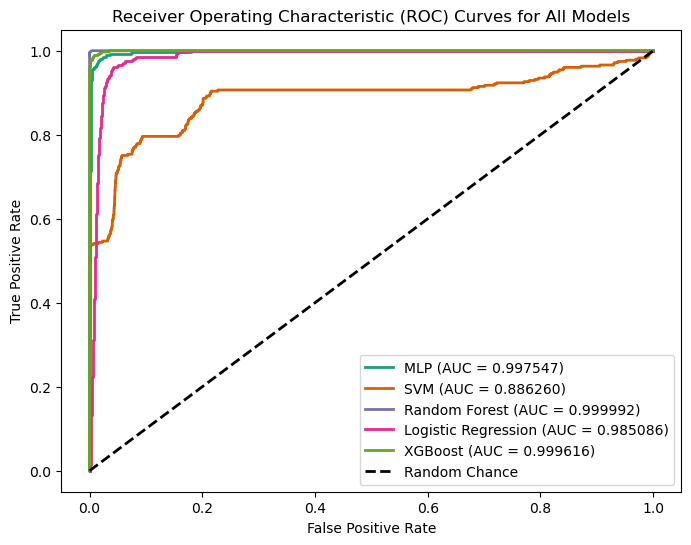

In [174]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Define a dictionary with the models
models = {
    "MLP": mlp,                  # Multi-layer Perceptron
    "SVM": svm,                  # Support Vector Machine (ensure probability=True or use decision_function)
    "Random Forest": rf,         # Random Forest
    "Logistic Regression": lr,   # Logistic Regression
    "XGBoost": xgb               # XGBoost
}

# Define a color palette for ROC curves using a similar approach as before
colors_model = sns.color_palette("Dark2", len(model_order))
roc_palette = dict(zip(model_order, colors_model))

plt.figure(figsize=(8, 6))

# Loop through each model to compute and plot its ROC curve
for model_name, model in models.items():
    # Check if the model has a predict_proba method; if not, use decision_function
    if hasattr(model, "predict_proba"):
        # Get the predicted probability for the positive class (assumed to be at index 1)
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        # Use decision_function if predict_proba is not available
        y_proba = model.decision_function(X_test)
    
    # Calculate false positive rate, true positive rate, and thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    # Compute the Area Under the Curve (AUC) score
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve for the current model
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.6f})', color=roc_palette[model_name], linewidth=2)

# Plot the ROC curve for random guessing (diagonal line)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Chance')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for All Models')
plt.legend(loc='lower right')
plt.show()

## Conclusion

In this notebook, we preprocessed the data, standardized the features, and split the data into training and test sets. We then reduced the training set via stratified sampling to speed up model training while maintaining class representativeness. 
Multiple ML models (MLP, SVM, Random Forest, Logistic Regression, and XGBoost) were trained on the sampled data. Their performance metrics were displayed separately and then aggregated in a summary table and grouped bar chart.

These results can help guide further tuning and feature selection for improving Low-Rate DDoS detection.